# Bayesian Linear Regression

In this notebook we demonstrate the use of the random walk Rosenbluth-Metropolis-Hasting algorithm on a simple linear regression.

In [3]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
import numpy as np
import blackjax

In [2]:
!pip install blackjax

     |████████████████████████████████| 74 kB 1.5 MB/s 


## The data

In [4]:
def compute_function_labels(slope: float, intercept: float, noise_std_dev: float, data: jnp.ndarray) -> jnp.ndarray:
    """
    Compute target values given function parameters and data.
    
    Args:
        slope: slope of the function (theta_1)
        intercept: intercept of the function (theta_0)
        data: input feature values (x)
        noise_std_dev: standard deviation of noise distribution (sigma)
        
    Returns:
        target values, either true or corrupted with noise
    """
    n_samples = len(data)
    if noise_std_dev == 0: # Real function
        return slope * data + intercept
    else: # Noise corrupted
        seed=4
        key = jax.random.PRNGKey(seed)
        return slope * data + intercept + np.random.normal(0, noise_std_dev, n_samples) #used nump here

In [5]:
# Set random seed to ensure reproducibility
seed = 4
from jax import random
key = random.PRNGKey(0)


# Generate true values and noise corrupted targets
n_datapoints = 100
intercept = -0.7
slope = 0.9
noise_std_dev = 0.5
noise_var = noise_std_dev**2
lower_bound = -1.5
upper_bound = 1.5

# Generate dataset key, shape=(), dtype=<class 'numpy.float64'>, minval=0.0, maxval=1.0
X = jax.random.uniform(key,shape = (n_datapoints,), minval = lower_bound, maxval = upper_bound)
X = X.reshape(100,1)
Y = compute_function_labels(slope, intercept, 0., X)
noise_corrupted_labels = compute_function_labels(slope, intercept, noise_std_dev, np.squeeze(X))

In [6]:
X.shape

(100, 1)

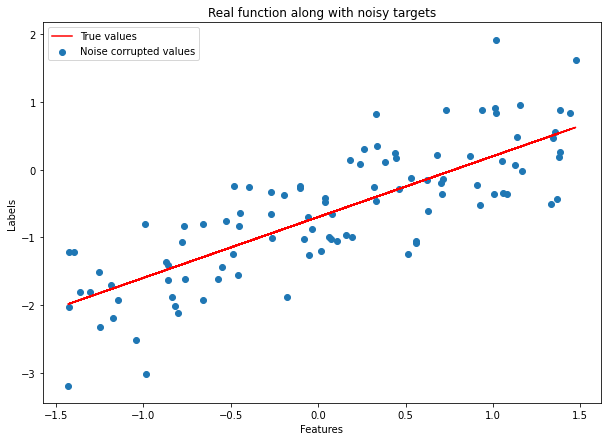

In [7]:
plt.figure(figsize=(10,7))
plt.plot(X, Y, color='r', label="True values")
plt.scatter(X, noise_corrupted_labels, label="Noise corrupted values")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Real function along with noisy targets")
plt.legend();

## The model

In [8]:

N,M = X.shape


def lin(z):
    return z


def log_linear(z):

    sigma = 0.5
    mu = 0
    return jnp.log(1 / jnp.sqrt(2 * jnp.pi * sigma**2)) - (1/(2 * sigma**2) * (Y-z)**2)


def logprob_fn(w, alpha=1.0):
    """The log-probability density function of the posterior distribution of the model."""
    an = X @ w
    log_likelihood_term = log_linear(an)
    prior_term = alpha * w @ w / 2

    return -prior_term + log_likelihood_term.sum()

## Posterior sampling

We use `blackjax`'s Random Walk RMH kernel to sample from the posterior distribution.

In [11]:
rng_key = random.PRNGKey(314)

w0 = random.multivariate_normal(rng_key, 0.1 + jnp.zeros(M), jnp.eye(M))

rmh = blackjax.rmh(logprob_fn, sigma=jnp.ones(M) * 0.7)
initial_state = rmh.init(w0)

In [12]:
w0
logprob_fn

<function __main__.logprob_fn>

Since `blackjax` does not provide an inference loop we need to implement one ourselves:

In [13]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

We can now run the inference:

In [14]:
_, rng_key = random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 5_000)

And display the trace:

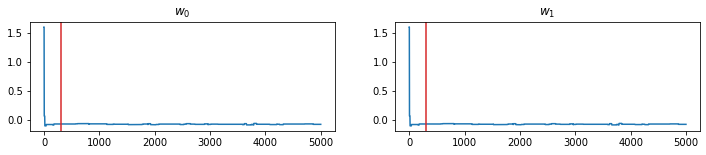

In [15]:
burnin = 300

fig, ax = plt.subplots(1, 2, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$w_{i}$")
    axi.axvline(x=burnin, c="tab:red")
plt.show()

In [16]:
chains = states.position[burnin:, :]
nsamp, _ = chains.shape

In [18]:
X.shape

(100, 1)

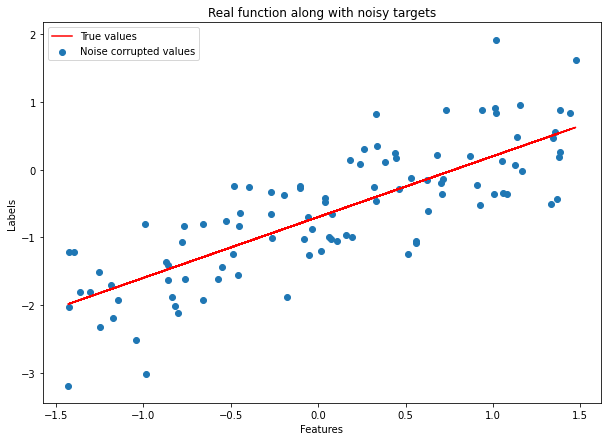

In [19]:
plt.figure(figsize=(10,7))
plt.plot(X, Y, color='r', label="True values")
plt.scatter(X, noise_corrupted_labels, label="Noise corrupted values")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Real function along with noisy targets")
plt.legend();

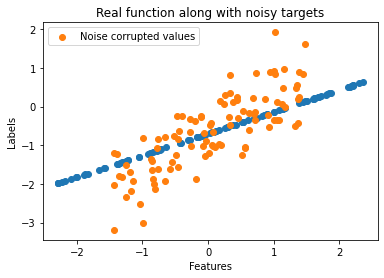

In [21]:

plt.scatter((*X.T*w0),Y)
plt.scatter(X, noise_corrupted_labels, label="Noise corrupted values")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Real function along with noisy targets")
plt.legend();